In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip  '/content/drive/MyDrive/Capstone.zip'

Archive:  /content/drive/MyDrive/Capstone.zip
   creating: Capstone/
   creating: Capstone/test/
   creating: Capstone/test/BrownSpot/
  inflating: Capstone/test/BrownSpot/IMG_3066_13_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_3077_18_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_3081_19_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_3165_26_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_3244_45_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_4831_47_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_4864_52_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_4904_56_11zon.jpg  
  inflating: Capstone/test/BrownSpot/shape 108 .jpg  
  inflating: Capstone/test/BrownSpot/shape 11 .jpg  
  inflating: Capstone/test/BrownSpot/shape 114 .jpg  
  inflating: Capstone/test/BrownSpot/shape 145 .jpg  
  inflating: Capstone/test/BrownSpot/shape 149 .jpg  
  inflating: Capstone/test/BrownSpot/shape 158 .jpg  
  inflating: Capstone/test/BrownSpot/shape 200 .jpg  


In [ ]:
#https://analyticsindiamag.com/a-comparison-of-4-popular-transfer-learning-models/
#https://keras.io/api/applications/efficientnet/ 
#https://vigneshgig.medium.com/xception-neural-network-transfer-learning-and-data-processing-using-ai-c3e7a4ea7bf2 

In [ ]:
#pip install split-folders tqdm

In [ ]:
import tensorflow as tf
import numpy as np
# import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Split Dataset into 3 part: Train, Val, and Test

In [ ]:
# splitfolders.ratio(
#     base_dir,
#     output='Capstone',
#     ratio=(.8,0.1,0.1)
# )

In [ ]:
train_dir = 'Capstone/train'
val_dir = 'Capstone/val' 
test_dir = 'Capstone/test'
os.listdir(train_dir)

['LeafBlast', 'Healthy', 'Hispa', 'BrownSpot']

In [ ]:
class_name = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=0.45,
                    brightness_range=(0.8,1.2), 
                    shear_range=0.2, 
                    zoom_range=(0.5,1.0), 
                    fill_mode='nearest', 
                    horizontal_flip=True,
                    vertical_flip=True,
                    )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224,224), 
    batch_size=32, 
    shuffle=True,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

Found 1811 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 230 images belonging to 4 classes.


Modeling

In [ ]:
from keras.callbacks import EarlyStopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

In [ ]:
from tensorflow.keras.applications import Xception
tfmodel = Xception(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224,224,3))
# tfmodel.trainable = False

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
from keras.models import Sequential
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D

In [ ]:
model = Sequential()
model.add(tfmodel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))      
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    callbacks=[monitor_val_acc,reduce_lr],
                    shuffle=True,
                    verbose=True,
                    validation_data=validation_generator)

Epoch 1/50
57/57 [==============================] - 51s 727ms/step - loss: 1.3291 - accuracy: 0.3484 - val_loss: 1.2223 - val_accuracy: 0.4643 - lr: 1.0000e-04
Epoch 2/50
57/57 [==============================] - 36s 628ms/step - loss: 1.0831 - accuracy: 0.5538 - val_loss: 1.0005 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 3/50
57/57 [==============================] - 37s 645ms/step - loss: 0.8708 - accuracy: 0.6455 - val_loss: 0.8738 - val_accuracy: 0.6652 - lr: 1.0000e-04
Epoch 4/50
57/57 [==============================] - 37s 643ms/step - loss: 0.6904 - accuracy: 0.7581 - val_loss: 0.6842 - val_accuracy: 0.7277 - lr: 1.0000e-04
Epoch 5/50
57/57 [==============================] - 36s 625ms/step - loss: 0.6307 - accuracy: 0.7769 - val_loss: 0.7061 - val_accuracy: 0.7411 - lr: 1.0000e-04
Epoch 6/50
57/57 [==============================] - 37s 652ms/step - loss: 0.5612 - accuracy: 0.8040 - val_loss: 0.6595 - val_accuracy: 0.7411 - lr: 1.0000e-04
Epoch 7/50
57/57 [======================

In [ ]:
model.save("Model.h5")

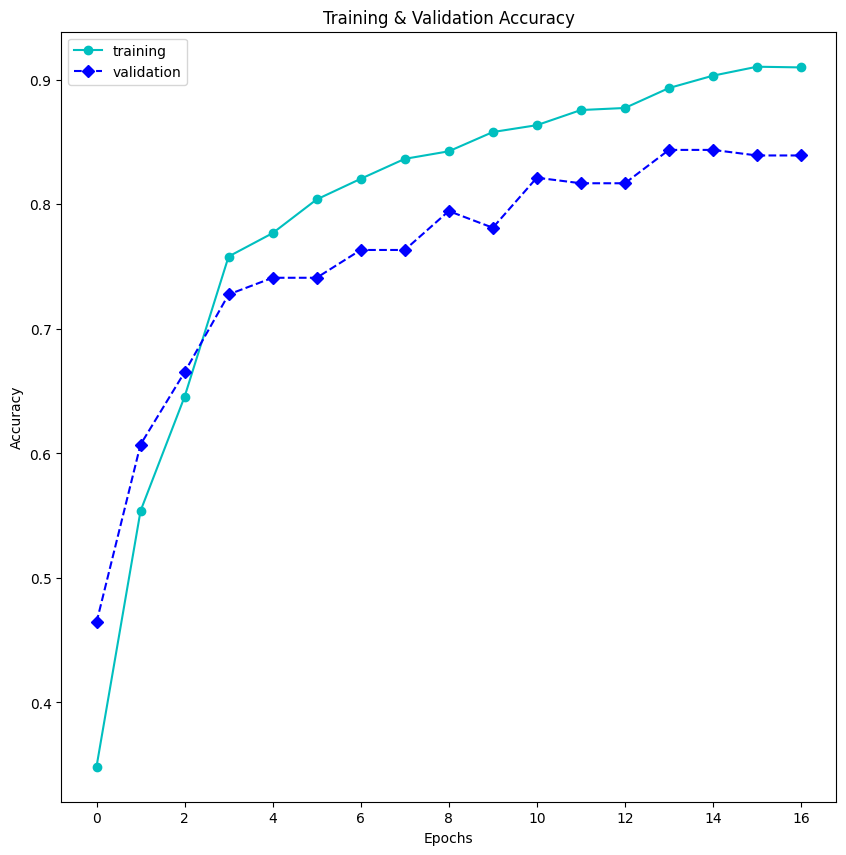

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['accuracy'])), 
         history.history['accuracy'],
         'co-',
         label='training')
plt.plot(range(len(history.history['val_accuracy'])), 
         history.history['val_accuracy'],
         'bD--',
         label='validation')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

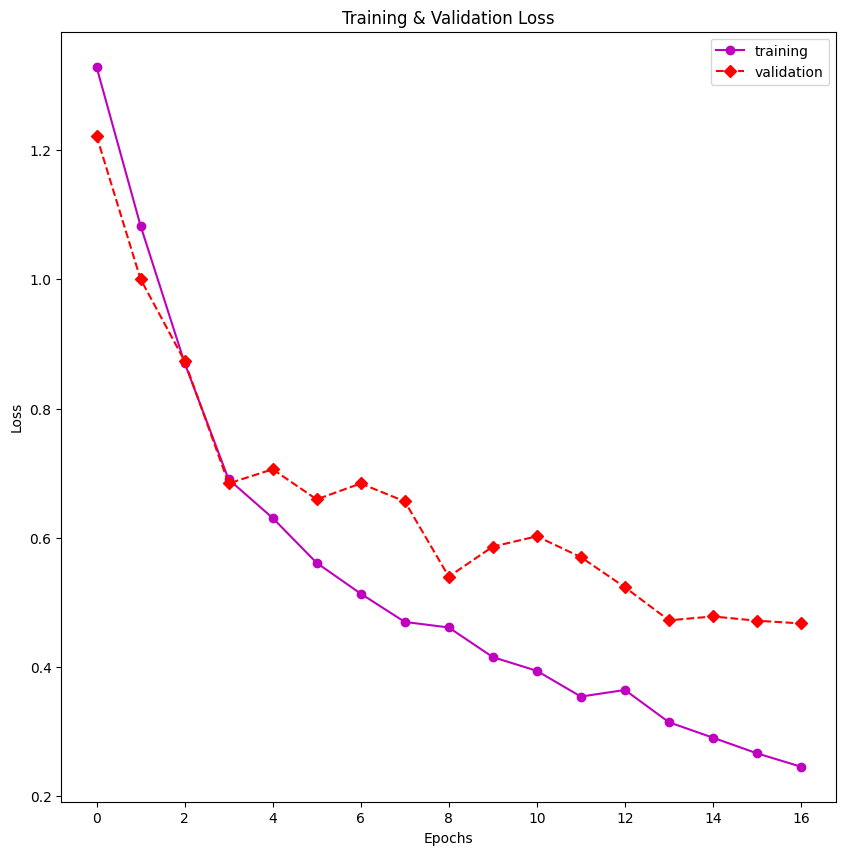

In [ ]:
plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['loss'])), 
         history.history['loss'],
         'mo-',
         label='training')
plt.plot(range(len(history.history['val_loss'])), 
         history.history['val_loss'],
         'rD--',
         label='validation')
plt.title('Training & Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
test_evaluate = model.evaluate(test_generator)

print(f'Test loss     : {test_evaluate[0]}')
print(f'Test accuracy : {round(test_evaluate[1],2)}')

8/8 [==============================] - 2s 235ms/step - loss: 0.4531 - accuracy: 0.8391
Test loss     : 0.453081339597702
Test accuracy : 0.84


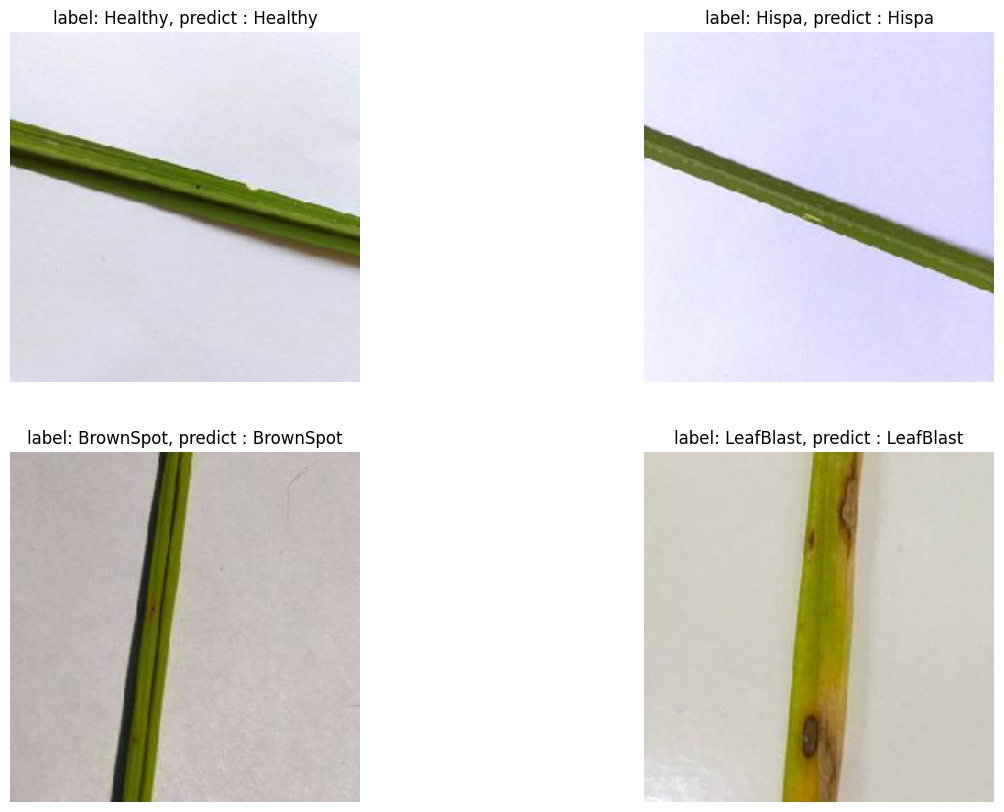

In [ ]:
image ,label = next(iter(test_generator))

plt.figure(figsize=(15,10))
for i in range(4) :
    TrueLabel = class_name[np.argmax(label[i])]
    plt.subplot(2,2,i+1)
    plt.axis('off')
    y_pred = np.argmax(model.predict(image[i][None,...],verbose=0))
    plt.imshow(tf.squeeze(image[i]))
    plt.title(f'label: {TrueLabel}, predict : {class_name[y_pred]}')